## map2loop: Code mess to estimate unit thickness, nowhere near working

#### Need to ignore points across faults, fold hinges. 
#### Now need to get points from neighbouring strat unit intersections, 
#### rotate around orig by dipdir, to get // to Y-axis then sort wrt Y and calc apparent_thickness = dist between points,
#### then true thickness by apparent_thickness*sin(DIP)

In [1]:
import os
from IPython.core.display import display, HTML
print(os.getcwd())
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


In [2]:
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
sys.path.insert(0,"../..")
print(os.getcwd())
rootdir=r'C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model\\'
os.chdir(rootdir)
print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model


In [3]:
mname='hams2' #root name of model input data

print(os.getcwd())
newdir=rootdir+mname
print(newdir)
os.chdir(newdir)


text=False    #display debug text
graphics=True #display debug images


model_base=-8200 # top could be found using highest point in topo data

minlong=117
maxlong=118
minlat=-23
maxlat=-22

minx=500057    #left hams
maxx=603028    #right
miny=7455348   #bottom
maxy=7567953   #top
    

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found

src_crs = 'epsg:2346'  #input data coord ref system (assumed to be geodetic lat/long WGS84)
dst_crs = 'epsg:28350' #model ref system (assumed to be something with metre coordinates)

# 'epsg:28350'  =  GDA_1994_MGA_Zone_50 
# 'epsg:4326'   =   wgs84 GEODETIC LAT/LONG 

orientation_decimate=0   # decimation of orientaiton data (0 = no decimation)
contact_decimate=30   # decimation of contact data (0 = no decimation)

gcode='GROUP_'
dcode='DIP'
ddcode='DIP_DIR'
ccode='CODE'


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model\\hams2


## Load geology map

In [4]:
# Extract point data from WAROX & geology map for gempy
##First we readin the WAROX and map from shapefiles, or wherever...

import geopandas as gpd
import os
from shapely.geometry import Polygon
from shapely.geometry import Point


%matplotlib inline
os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


geology = gpd.read_file('./data/geol_clip.shp')
print(geology.crs)


{'init': 'epsg:28350'}


## Basic explode code

In [5]:
#https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
    
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def explode(indf):
#    indf = gpd.GeoDataFrame.from_file(indata)
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

## Load topological sorted surfaces

In [6]:
ag=open('./tmp/'+mname+'_all_sorts.csv',"r")
contents =ag.readlines()
ag.close

ulist=[]
for i in range(1,len(contents)):
    cont_list=contents[i].split(",")
    ulist.append([i, cont_list[4].replace("\n","")])
print(ulist)


[[1, 'P_-WYa-st'], [2, 'P_-WYm-sp'], [3, 'P_-WYd-kd'], [4, 'P_-SKq-stq'], [5, 'P_-SKb-bb'], [6, 'P_-TK-s'], [7, 'P_-TKa-xs-k'], [8, 'P_-TKo-stq'], [9, 'P_-TKk-sf'], [10, 'P_-HAo-ci'], [11, 'P_-HAw-fr'], [12, 'P_-HAj-xci-od'], [13, 'P_-HAb-cib'], [14, 'A-HAS-xsl-ci'], [15, 'A-HAd-kd'], [16, 'A-HAm-cib'], [17, 'A-FOj-xs-b'], [18, 'A-FOu-bbo'], [19, 'A-FOp-bs'], [20, 'A-FOo-bbo'], [21, 'A-FOh-xs-f'], [22, 'A-FOr-b'], [23, 'A-s-PMI'], [24, 'A-s-PRK'], [25, 'A-b-PRK']]


## Load all basal contact points

In [7]:
import math
def angle(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    inner_product = x1*x2 + y1*y2
    len1 = math.hypot(x1, y1)
    len2 = math.hypot(x2, y2)
    dot=math.degrees(math.acos(inner_product/(len1*len2)))
    return 90-math.fabs(90-dot)

def pairs(lst):
    for i in range(1, len(lst)):
        yield lst[i-1], lst[i]

        #https://www.geeksforgeeks.org/program-check-three-points-collinear/

# Python program to check 
# if three points are collinear 
# or not using area of triangle. 
  
# function to check if  
# point collinear or not 
def collinear(x1, y1, x2, y2, x3, y3): 
      
    """ Calculation the area of   
        triangle. We have skipped  
        multiplication with 0.5 to 
        avoid floating point computations """
    a = x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2) 
    b=x1 * (y2 - y3)
    c=x2 * (y3 - y1)
    d=x3 * (y1 - y2) 
  
    #if (a < 0.000001): 
    #    print ("Yes",a,b,c,d)
    #else: 
    #    print ("No",a,b,c,d)
    return(a< 0.000001)
  
# This code is contributed 
# by Sachin Bisht 

import rasterio

dataset = rasterio.open('./dtm\\'+mname+'_dtm_rp.tif')

def height_from_srtm(x,y):
    locations=[(x,y)]
    for val in dataset.sample(locations):
        return(str(val).replace("[","").replace("]",""))


## Create basal contact points with orientation from orientations and basal points

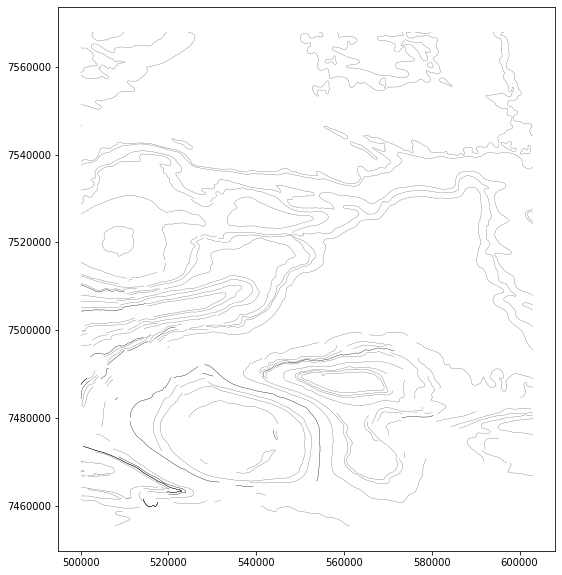

In [8]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import MultiPoint,Point,LineString
from shapely.ops import nearest_points
import math

contacts = gpd.read_file('./tmp/basal_contacts2.shp') #load orientation data as geopandas dataframe 

warox = gpd.read_file('./data/warox_clip.shp') #load orientation data as geopandas dataframe 

contacts.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2)

In [9]:
f=open('./output/'+mname+'_projected_dip_contacts2.csv',"w")
f.write('id,x,y,z,DIP,DIP_DIR,polarity,CODE,GROUP_\n')
#print("len=",len(contacts))
i=0
for acontact in contacts.iterrows():   #loop through distinct linestrings
    #display(acontact[1].geometry)
    thegroup=acontact[1]['GROUP_']
    #print("thegroup=",thegroup)
    is_wrx=warox['GROUP_'] == thegroup # subset orientations to just those with this group
    all_wrx = warox[is_wrx]

    for awrx in all_wrx.iterrows(): # loop through valid orientations
        #print(awrx[1].geometry,awrx[1]['GROUP_'])
        orig = Point(awrx[1]['geometry'])
        nearp = acontact[1].geometry.interpolate(acontact[1].geometry.project(orig))
        if(nearp.distance(orig)<5000):
            #print(acontact[1]['CODE'],awrx[1]['DIP'],orig,np)                  
            for line in acontact[1].geometry: # loop through line segments
                for pair in pairs(list(line.coords)): # loop through line segments
                    segpair=LineString((pair[0],pair[1]))
                    if segpair.distance(nearp)< 0.0001: # line segment closest to close point
                        ddx=math.sin(math.radians(awrx[1]['DIP_DIR']))
                        ddy=math.cos(math.radians(awrx[1]['DIP_DIR']))
                        dlsx=pair[0][0]-pair[1][0]
                        dlsy=pair[0][1]-pair[1][1]
                        lsx=dlsx/math.sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        lsy=dlsy/math.sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        angle=math.degrees(math.acos((ddx*lsx)+(ddy*lsy)))
                        #print(i,angle,ls_ddir,lsx,lsy,awrx[1]['DIP_DIR'])
                        if(math.fabs(angle-90)<30.0): # dip_dir normal and contact are close enough to parallel
                            height= height_from_srtm(nearp.x,nearp.y)
                            ls_ddir=math.degrees(math.atan2(lsy,-lsx)) #normal to line segment
                            #print(i,ddx,ddy,lsx,lsy,ls_ddir,awrx[1]['DIP_DIR'])
                           
                            if (ddx*lsy)+(-ddy*lsx)<0: #dot product tests right quadrant
                                ls_ddir=(ls_ddir-180)%360
                            ostr=str(i)+","+str(nearp.x)+","+str(nearp.y)+","+height+","+str(awrx[1]['DIP'])+","+str(ls_ddir)+",1,"+acontact[1]['CODE']+","+acontact[1]['GROUP_']+"\n" 
                            f.write(ostr)
                            i=i+1


f.close()

## Estimate layer thicknesses

In [10]:
warox = gpd.read_file('./data/warox_clip.shp') #load orientation data as geopandas dataframe 
contacts = gpd.read_file('./tmp/basal_contacts2.shp') #load orientation data as geopandas dataframe 

f=open('./output/'+mname+'_estimated_layer_thicknesses.csv',"w")
f.write('id,x,y,CODE,thickness\n')

all_sorts=pd.read_csv('./tmp/'+mname+'_all_sorts.csv')
#display(all_sorts)
i=0
print("id,x,y,code,group")
for apair in all_sorts.iterrows():
    for bpair in all_sorts.iterrows():
        if(int(apair[1]['index'])==(int(bpair[1]['index'])+1) and apair[1]['group']==bpair[1]['group'] ):
            #print(apair[1]['code'],apair[1]['group'])
            #print(warox.shape)
            is_wrx=warox['GROUP_'] == apair[1]['group'] # subset orientations to just those with this group
            all_wrx = warox[is_wrx]      
            #print(all_wrx.shape)
            is_contacta=contacts['CODE'] == apair[1]['code'] # subset contacts to just those with a code
            acontacts = contacts[is_contacta]
            
            is_contactb=contacts['CODE'] == bpair[1]['code'] # subset contacts to just those with b code
            bcontacts = contacts[is_contactb]
            
            crossings=np.zeros((1000,4))
            
            for awrx in all_wrx.iterrows(): # loop through valid orientations
                
                dx1=math.sin(math.radians(awrx[1]['DIP_DIR']))*1e5
                dy1=math.cos(math.radians(awrx[1]['DIP_DIR']))*1e5
                dx2=-dx1
                dy2=-dy1
                p1=Point((dx1+awrx[1]['geometry'].x,dy1+awrx[1]['geometry'].y))
                p2=Point((dx2+awrx[1]['geometry'].x,dy2+awrx[1]['geometry'].y))
                ddline=LineString((p1,p2))
                orig = Point(awrx[1]['geometry'])

                for acontact in acontacts.iterrows():   #loop through distinct linestrings for upper contact
                    #print(acontact[1]['CODE'],apair[1]['code'])
                    #break
                    if(ddline.intersects(acontact[1].geometry)): 
                        isects=ddline.intersection(acontact[1].geometry)
                        #print(type(isects),isects)
                        if(isects.geom_type=="MultiPoint"):
                            for pt in isects: 
                                if(pt.distance(orig)<1000):
                                    print(i,",", pt.x, ",",pt.y,",",apair[1]['code'],",",apair[1]['group'])
                                    crossings[i,0]=i
                                    crossings[i,1]=pt.x
                                    crossings[i,2]=pt.y
                                    crossings[i,3]=int(apair[1]['index'])
                                    i=i+1
                        else:
                            if(isects.distance(orig)<1000):
                                print(i,",", isects.x,",", isects.y,",",apair[1]['code'],",",apair[1]['group'])
                                crossings[i,0]=i
                                crossings[i,1]=pt.x
                                crossings[i,2]=pt.y
                                crossings[i,3]=int(apair[1]['index'])
                                i=i+1
                
                for bcontact in bcontacts.iterrows():   #loop through distinct linestrings for lower contact
                    #break
                    if(ddline.intersects(bcontact[1].geometry)): 
                        isects=ddline.intersection(bcontact[1].geometry)
                        if(isects.geom_type=="MultiPoint"):
                            for pt in isects: 
                                if(pt.distance(orig)<15000):
                                    print(i,",", pt.x, ",",pt.y,",",bpair[1]['code'],",",bpair[1]['group'])
                                    crossings[i,0]=i
                                    crossings[i,1]=pt.x
                                    crossings[i,2]=pt.y
                                    crossings[i,3]=int(apair[1]['index'])
                                    i=i+1
                        else:
                            if(isects.distance(orig)<15000):
                                print(i,",", isects.x,",", isects.y,",",bpair[1]['code'],",",bpair[1]['group'])
                                crossings[i,0]=i
                                crossings[i,1]=pt.x
                                crossings[i,2]=pt.y
                                crossings[i,3]=int(apair[1]['index'])
                                i=i+1
                

id,x,y,code,group
0 , 503517.6591896642 , 7469649.220456804 , P_-TK-s , Turee Creek Group
1 , 503306.7931686398 , 7469692.746706662 , P_-TK-s , Turee Creek Group
2 , 506347.23531252716 , 7507214.949096731 , P_-TK-s , Turee Creek Group
3 , 506734.2878589084 , 7501679.839807122 , P_-TK-s , Turee Creek Group
4 , 519176.2989944205 , 7510577.864206427 , P_-HAo-ci , Hamersley Group
5 , 522003.25098897575 , 7511263.4492883 , P_-HAo-ci , Hamersley Group
6 , 513175.2595870358 , 7512004.91182013 , P_-HAo-ci , Hamersley Group
7 , 512360.4959606062 , 7509497.327220379 , P_-HAo-ci , Hamersley Group
8 , 511053.0975996128 , 7505473.568808219 , P_-HAo-ci , Hamersley Group
9 , 508040.55726586835 , 7496201.923017978 , P_-HAo-ci , Hamersley Group
10 , 508040.55726586835 , 7496201.923017978 , P_-HAo-ci , Hamersley Group
11 , 519116.346869558 , 7541354.573763469 , P_-HAw-fr , Hamersley Group
12 , 519085.15765032294 , 7541651.319362314 , P_-HAw-fr , Hamersley Group
13 , 539518.9712941664 , 7521625.299932528

117 , 530705.7461415365 , 7500676.542322809 , P_-HAj-xci-od , Hamersley Group
118 , 539816.4860232514 , 7522140.100427552 , P_-HAj-xci-od , Hamersley Group
119 , 536559.7934930685 , 7500775.518485127 , P_-HAj-xci-od , Hamersley Group
120 , 540688.2785449532 , 7522014.7328386735 , P_-HAj-xci-od , Hamersley Group
121 , 542955.2854492222 , 7504969.149040387 , P_-HAj-xci-od , Hamersley Group
122 , 552640.602675755 , 7515573.585832984 , P_-HAj-xci-od , Hamersley Group
123 , 550149.5039241397 , 7520613.260632593 , P_-HAj-xci-od , Hamersley Group
124 , 538972.8642384984 , 7522163.475230113 , P_-HAj-xci-od , Hamersley Group
125 , 549683.9767032122 , 7514092.073051221 , P_-HAj-xci-od , Hamersley Group
126 , 547492.7269928869 , 7512900.133550231 , P_-HAj-xci-od , Hamersley Group
127 , 548255.4169552554 , 7521617.719710895 , P_-HAj-xci-od , Hamersley Group
128 , 547952.3973881966 , 7521755.343040935 , P_-HAj-xci-od , Hamersley Group
129 , 549067.7258590435 , 7513819.368608957 , P_-HAj-xci-od , Ha

227 , 544735.9975133562 , 7523206.6009097835 , A-HAd-kd , Hamersley Group
228 , 546049.043189508 , 7527019.9624453485 , A-HAd-kd , Hamersley Group
229 , 544638.8247722408 , 7523209.66427508 , A-HAd-kd , Hamersley Group
230 , 545350.2876425603 , 7527244.570716855 , A-HAd-kd , Hamersley Group
231 , 540447.0910537734 , 7529275.035283804 , A-HAd-kd , Hamersley Group
232 , 543159.4130958238 , 7528052.669995142 , A-HAd-kd , Hamersley Group
233 , 577331.4957890378 , 7488812.705562837 , A-HAd-kd , Hamersley Group
234 , 573951.9113684382 , 7481565.163384415 , A-HAd-kd , Hamersley Group
235 , 576138.6456728588 , 7485643.993343315 , A-HAd-kd , Hamersley Group
236 , 577486.1776524916 , 7486900.587243376 , A-HAd-kd , Hamersley Group
237 , 578370.2672357529 , 7487725.014117264 , A-HAd-kd , Hamersley Group
238 , 523039.2686288807 , 7542371.012823122 , A-HAd-kd , Hamersley Group
239 , 523325.76856858825 , 7543080.1250573965 , A-HAd-kd , Hamersley Group
240 , 522028.91163266764 , 7538211.934783845 , A-

343 , 562027.3001088692 , 7467529.336750407 , A-FOu-bbo , Fortescue Group
344 , 572690.6372223514 , 7470386.569318586 , A-FOu-bbo , Fortescue Group
345 , 578521.3699357363 , 7470459.6089331405 , A-FOu-bbo , Fortescue Group
346 , 573199.7024095111 , 7469711.697336997 , A-FOu-bbo , Fortescue Group
347 , 577853.7182028444 , 7466930.48895766 , A-FOu-bbo , Fortescue Group
348 , 578519.3622103572 , 7470519.259613348 , A-FOu-bbo , Fortescue Group
349 , 583264.5844054873 , 7479700.795156557 , A-FOu-bbo , Fortescue Group
350 , 586814.8487778918 , 7480329.051172618 , A-FOu-bbo , Fortescue Group
351 , 586611.2780616957 , 7480275.916358972 , A-FOu-bbo , Fortescue Group
352 , 581601.8805037554 , 7479316.164456411 , A-FOu-bbo , Fortescue Group
353 , 530828.6786907102 , 7490633.981496935 , A-FOp-bs , Fortescue Group
354 , 533290.593718842 , 7488527.708471198 , A-FOp-bs , Fortescue Group
355 , 518456.91658891033 , 7471371.322733781 , A-FOp-bs , Fortescue Group
356 , 518437.694681478 , 7471384.23088991

In [11]:
# Need to ignore points across faults. 
# Now need to get points from neighbouring strat unit intersections, 
# rotate around orig by dipdir, to get // to Y-axis then sort wrt Y and calc apparent_thickness = dist between points,
# then true thickness by apparent_thickness*sin(DIP)